#Land Use Classification & Change (LUCC) study Samos, Greece
*Kazi Sajjad Hossain, Tim Grandjean, Archipelagos, November 2020*



##Introduction
###Background
Effective management and monitoring of Aegean islands is critical for the environmental conservation of the ecosysetms. Methods for detecting should be meaningful and significant to monitor large areas over time. The rate at which cities and towns grow, or the urbanisation rate, is an important indicator of the sustainability of towns and cities. Rapid, unplanned urbanisation can result in poor social, economic, and environmental outcomes due to inadequate and overburdened infrastructure and services creating congestion, worsening air pollution, and leading to a shortage of adequate housing. Further, extensive use of agriculture and forest are a threat for the rich but critic ecosystems of the islands. 

Satellite imagery from the EU Copernicus Sentinel-2 or Landsat missions are freely available. The resolution makes it perfect for monitoring changes over large areas of land and extensive periods. 

##Pre-defined requirements

###Settings
You should only adapt the next code box, the rest of the script could run without issues.

In [ ]:
#Settings, you should only adapt the following lines
root = "/content/drive/MyDrive/Kazi/"
shp_boundary = "/content/drive/MyDrive/Kazi/shapefile/"
AOI = "Samos"
default_year = "2009"
default_constellation = "L57"   #for landsat8 "L8" for landsat 5 or 7 "L57"
image_folder = root + "original_data/" + AOI + "/"
shapefile_folder = root + "shapefile/" + AOI + "/"
result_folder = root + "result/" + AOI + "/"

###Install packages

In [ ]:
#Import default packages
import subprocess
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.cluster import KMeans
from skimage import exposure
from skimage.segmentation import quickshift
from sklearn.ensemble import RandomForestClassifier
import gdal
import ogr
import scipy 
import pandas as pd

#Install non default colaboratory packages
try:
    import geopandas
except ImportError:
    print('geopandas package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])
    import geopandas as gpd

#Install non default colaboratory packages
try:
    import rasterio
    from rasterio.plot import plotting_extent
except ImportError:
    print('rasterio package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'rasterio'])
    import rasterio as rio
    from rasterio.plot import plotting_extent

try:
    import earthpy as et
    import earthpy.spatial as es
    import earthpy.plot as ep
except ImportError:
    print('earthpy package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'earthpy'])
    import earthpy as et
    import earthpy.spatial as es
    import earthpy.plot as ep

earthpy package not installed. Installing ...


###Loading data
Landsat data can be downloaded to observe land use change more or less since 1984. We assume you are able to download the imagery seperately, and place it in the image folder. For every year, you should have a seperate folder. First we index all the images, clip them for our area of interest (AOI), in this example Samos and stack the bands together.

We assume that every image before 2015 is Landsat 5 or 7, and after 2015 is Landsat 8 for further analyses. But be careful and adapt if needed for your case.

In [ ]:
#index shapefile
shapefile = glob.glob(os.path.join(shapefile_folder, "*.shp"))[0]
aoi_shp =gpd.read_file(shapefile)

image_selection = []

for root, dirnames, filenames in os.walk(image_folder):
  dirnames.sort()
  for year in dirnames:
    if year != ".ipynb_checkpoints":
      year_folder = image_folder + year + "/"
      all_landsat_band= glob.glob(os.path.join(year_folder, "*.TIF"))
      all_landsat_band.sort()
      if int(year) < 2015:
        constellation = "L57"
      elif int(year) >= 2015:
        constellation = "L8"

      image_meta = [year, constellation]
      image_selection = image_selection + [image_meta]
      print(image_selection)
      with rio.open(all_landsat_band[3]) as landsat_raster:

        # Reproject the fire boundary shapefile to be the same CRS as the Landsat data
        crop_raster_profile = landsat_raster.profile
        boundary_crs = aoi_shp.to_crs(crop_raster_profile["crs"])

        # Crop the landsat image to the extent of the fire boundary
        landsat_band, landsat_metadata = es.crop_image(landsat_raster, boundary_crs) 
      
      result_folder_year = result_folder + year + '/'

      if not os.path.isdir(result_folder_year):
        os.mkdir(result_folder_year)

      cropped_file_list = es.crop_all(raster_paths=all_landsat_band,
                                output_dir= result_folder_year,
                                geoms=boundary_crs,
                                overwrite=True,
                                verbose=True)

      result_folder_stack = result_folder_year + 'stack.tif'

      land_stack, land_meta = es.stack(cropped_file_list, out_path=result_folder_stack)

###Example of the AOI and image

In [ ]:
extent = plotting_extent(land_stack[0], land_meta["transform"])

fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    land_stack,
    rgb=(3, 2, 1),          #(3, 2, 1) for landsat 8  -  (2, 1, 0) for landsat 5 or 7
    ax=ax,
    stretch=True,
    extent=extent,
    str_clip=0.5,
    title="RGB Image of cropped Raster",
)
plt.show()

##Define functions for calculating indices
First, we will calculate indices for change in the land for the default year. If this works, we will repeat it later for all imagery.

In [ ]:
stack_folder = result_folder_year = result_folder + default_year + '/stack.tif'
with rio.open(stack_folder, 'r') as land_stack:
    land_arr = land_stack.read()

In [ ]:
landsat_metadata2 = landsat_metadata
landsat_metadata2['dtype'] = rio.float32

###Mask the water areas
As we study Aegean islands, it would be the first step to mask out the water area. The code below used the simply Normalized Difference Water Index (NDWI) to calculate the area with water, and create a mask layer.

In [ ]:
#Define function for NDWI
def calNDWI(image, satellite):
  if satellite == "L8":
    return es.normalized_diff(image[2], image[4])
  else:
    return es.normalized_diff(image[1], image[3])

#calculate NDWI for the image stack
ndwi_ds = calNDWI(land_arr, default_constellation)

/usr/local/lib/python3.6/dist-packages/earthpy/spatial.py:112: Warning: Divide by zero produced infinity values that will be replaced with nan values
  Warning,


Create a water mask, water is classified as numpy nan object and land as 1. We test the treshold simply manually to define it as 0.5.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


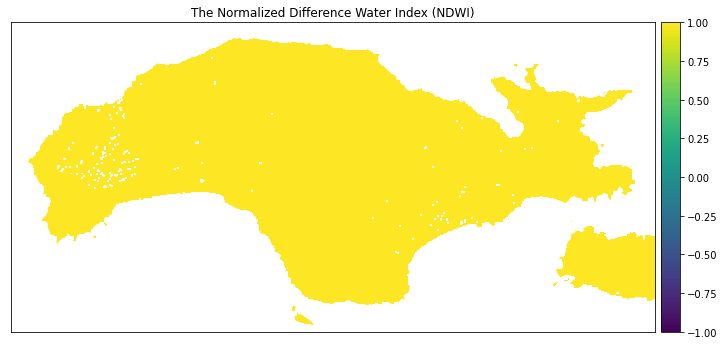

In [ ]:
water_mask = ndwi_ds
water_mask[water_mask >= 0.5 ] = 1
water_mask[water_mask < 0.5 ] = np.nan

#Plot Water mask
ep.plot_bands(water_mask, cmap="viridis", title="The Normalized Difference Water Index (NDWI)", vmin=-1, vmax=1)

#Save NDWI
with rio.open(result_folder + default_year + '/NDWI_index.tif', 'w', **landsat_metadata2) as dst:
  dst.write(ndwi_ds.astype(rio.float32), 1)

###Calculate The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI)
We aim to calculate an index to classifiy the level of urbanisation. The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is an index like all normalised differences indicies with a range of [-1, 1]. ENDISI includes indicies like MNDWI, swir_diff and alpha. More information can be found in the paper of Chen et al. 2020


In [ ]:
def calMNDWI(image, satellite):
  if satellite == "L8":
    return es.normalized_diff(image[2], image[5])
  else:
    return es.normalized_diff(image[1], image[4])

def SWIRdif(image, satellite):
  if satellite == "L8":
    return image[5]/image[6]
  else:
    return image[4]/image[6]

def alpha(image, satellite):
  if satellite == "L8":
    return (2 * (np.mean(image[1]))) / (np.mean(SWIRdif(image, satellite)) +
                                            np.mean(calMNDWI(image, satellite)**2))  
  else:
    return (2 * (np.mean(image[0]))) / (np.mean(SWIRdif(image, satellite)) +
                                            np.mean(calMNDWI(image, satellite)**2))
    
def ENDISI(image, satellite):
  mndwi = calMNDWI(image, satellite)
  swir_diff_ds = SWIRdif(image, satellite)
  alpha_ds = alpha(image, satellite)

  if satellite == "L8":  
    return (image[1] - (alpha_ds) *
            (swir_diff_ds + mndwi**2)) / (image[1] + (alpha_ds) *
                                       (swir_diff_ds + mndwi**2))  
  else:
    return (image[0] - (alpha_ds) *
            (swir_diff_ds + mndwi**2)) / (image[0] + (alpha_ds) *
                                       (swir_diff_ds + mndwi**2))

Let's plot the ENDISI images so we can see if the urban areas are distinguishable

/usr/local/lib/python3.6/dist-packages/earthpy/spatial.py:112: Warning: Divide by zero produced infinity values that will be replaced with nan values
  Warning,


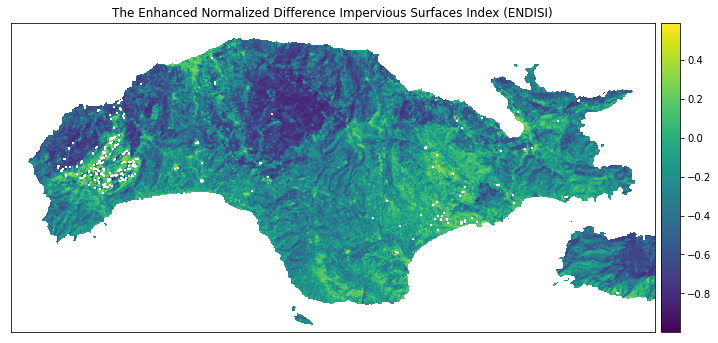

In [ ]:
#Calculate ENDISI
endisi_ds = ENDISI(land_arr, default_constellation)

#Water mask ENDISI
endisi_ds = endisi_ds * water_mask

#Plot ENDISI
ep.plot_bands(endisi_ds, cmap="viridis", title="The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI)")

We need to define a threshold for the urban extent. Values above this threshold will be labelled as 'Urban', below will be excluded from urban extent. We test it simply manually to define the threshold as 0.1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


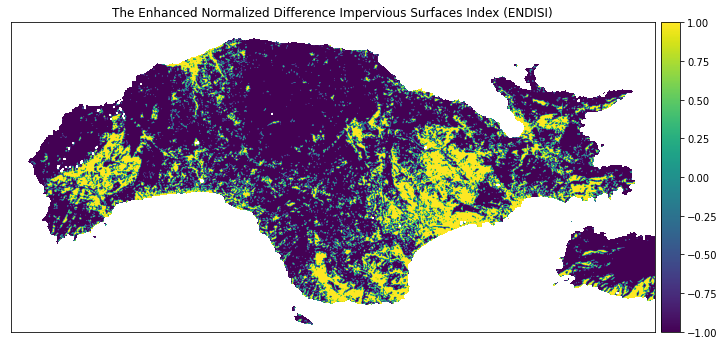

In [ ]:
#Mask everything out except urbanized areas
endisi_ds[endisi_ds < -0.1 ] = -1
endisi_ds[endisi_ds >= -0.1 ] = 1

#Plot ENDISI
ep.plot_bands(endisi_ds, cmap="viridis", title="The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI)")

In [ ]:
#Export ENDISI
with rio.open(result_folder + default_year + '/ENDISI_index.tif', 'w', **landsat_metadata2) as dst:
  dst.write(endisi_ds.astype(rio.float32), 1)

###Calculate vegetation indices

There is a large number of spectral indices that can analyze various aspects of vegetation. We calculate few indicies in this example.

1. The Normalized Difference Vegetation Index (NDVI) is a numerical indicator that uses the red and near-infrared spectral bands. NDVI is highly associated with vegetation content. High NDVI values correspond to areas that reflect more in the near-infrared spectrum. Higher reflectance in the near-infrared correspond to denser and healthier vegetation (GU, 2019).

2. SAVI is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low. Landsat Surface Reflectance-derived SAVI is calculated as a ratio between the R and NIR values with a soil brightness correction factor (L) defined as 0.5 to accommodate most land cover types (USGS, 2019).

3. Simplest ratio-based index is called the Ratio Vegetation Index (RVI). This index is simply the reflectance in the NIR band divided by the reflectance in the red band. A larger SR value indicates healthy vegetation, while lower values indicate soil, water or ice. 



/usr/local/lib/python3.6/dist-packages/earthpy/spatial.py:112: Warning: Divide by zero produced infinity values that will be replaced with nan values
  Warning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


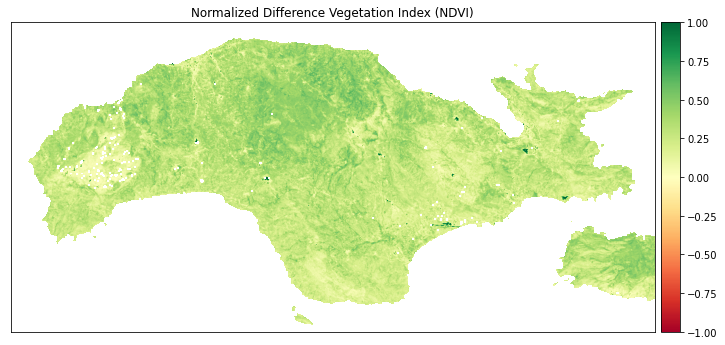

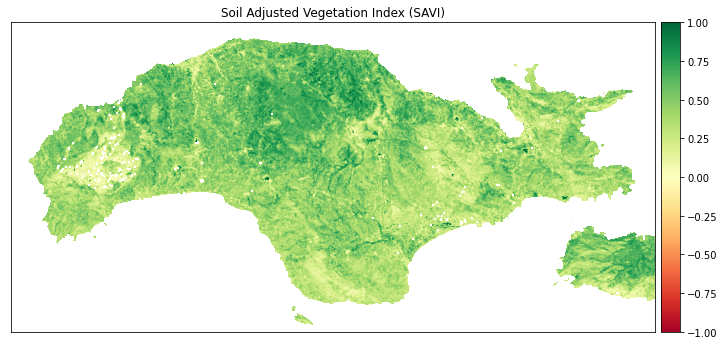

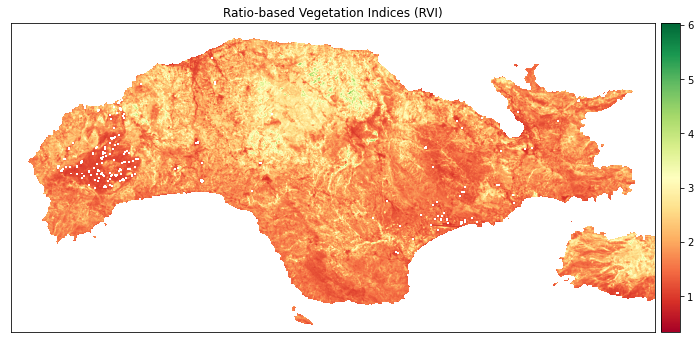

In [ ]:
#Define functions for indicies and ratios
def calNDVI(image, satellite):
  if satellite == "L8":
    return es.normalized_diff(image[4], image[3])
  else:
    return es.normalized_diff(image[3], image[2])

def calSAVI(image, satellite):
  if satellite == "L8":
    return ((image[4] - image[3]) / (image[4] + image[3] + 0.5)) * (1 + 0.5)
  else:
    return ((image[3] - image[2]) / (image[3] + image[2] + 0.5)) * (1 + 0.5)

def calRVI(image, satellite):
  if satellite == "L8":
    return image[4]/image[3]
  else:
    return image[3]/image[2]

#Calculate indices and water mask them
ndvi_ds = calNDVI(land_arr, default_constellation) * water_mask
savi_ds = calSAVI(land_arr, default_constellation) * water_mask
rvi_ds = calRVI(land_arr, default_constellation) * water_mask

ndvi_ds[ndvi_ds > 1] = 1
savi_ds[savi_ds > 1] = 1

#Plot indices
ep.plot_bands(ndvi_ds, cmap="RdYlGn", cols=1, title="Normalized Difference Vegetation Index (NDVI)", vmin=-1, vmax=1)
ep.plot_bands(savi_ds, cmap="RdYlGn", cols=1, title="Soil Adjusted Vegetation Index (SAVI)", vmin=-1, vmax=1)
ep.plot_bands(rvi_ds, cmap="RdYlGn", cols=1, title="Ratio-based Vegetation Indices (RVI)")

#Export indices
with rio.open(result_folder + default_year + '/NDVI_index.tif', 'w', **landsat_metadata) as dst:
  dst.write(ndvi_ds.astype(rio.float32), 1)

with rio.open(result_folder + default_year + '/SAVI_index.tif', 'w', **landsat_metadata) as dst:
  dst.write(savi_ds.astype(rio.float32), 1)

with rio.open(result_folder + default_year + '/RVI_index.tif', 'w', **landsat_metadata) as dst:
  dst.write(rvi_ds.astype(rio.float32), 1)

###Classify NDVI
Next, you can categorize (or classify) the NDVI results into useful classes. Values under 0 will be classified together as no vegetation. Additional classes will be created for bare area and low, moderate, and high vegetation areas. This script is from Earthpy.

In [ ]:
#urbanised areas
urbanised = endisi_ds
urbanised[urbanised < 0] = -1
urbanised[urbanised >= 0] = 2

mask_urban = np.fmax(ndvi_ds, urbanised)


# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, 1, np.inf]
ndvi_landsat_class = np.digitize(mask_urban, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndvi_ds), ndvi_landsat_class
)
np.unique(ndvi_landsat_class)
ndvi_landsat_class = ndvi_landsat_class * water_mask

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


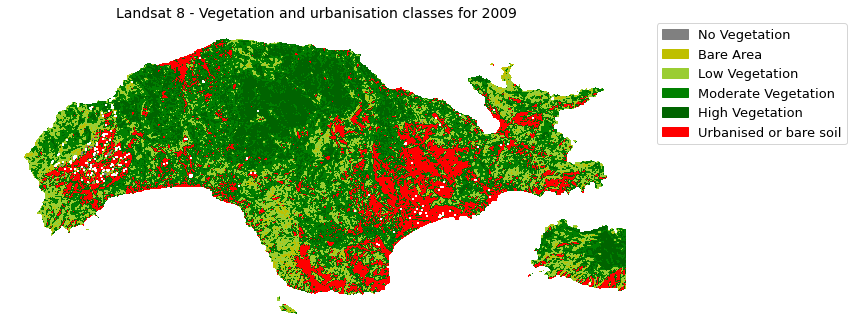

In [ ]:

# Define color map
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen", "r"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "No Vegetation",
    "Bare Area",
    "Low Vegetation",
    "Moderate Vegetation",
    "High Vegetation",
    "Urbanised or bare soil"
  ]

# Get list of classes
classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:6]

# Plot your data
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(ndvi_landsat_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Landsat 7 - Vegetation and urbanisation classes for " + default_year,
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

###Stack all indices and ratios together


In [ ]:
#list all indices
file_list = glob.glob(os.path.join(result_folder + default_year + "/", "*index.tif"))
file_list.sort()

# Read metadata of first file
with rio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rio.open(result_folder + default_year + '/stack_indices.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rio.open(layer) as src1:
            data = src1.read(1)
            data[np.isnan(data)] = -99999
            dst.write_band(id, data)

##Unsupervised classification
Unsupervised classification is where the outcomes (groupings of pixels with common characteristics) are based on the software analysis of an image without the user providing sample classes. The computer uses techniques to determine which pixels are related and groups them into classes. The user can specify which algorism the software will use and the desired number of output classes but otherwise does not aid in the classification process. However, the user must have knowledge of the area being classified when the groupings of pixels with common characteristics produced by the computer have to be related to actual features on the ground (such as wetlands, developed areas, coniferous forests, etc.). In this method, we describe a simple implementation of the K-Means algorithm for unsupervised image classification. 

We will analyse the stack for the default year we created. So the unsupervised classification is absed on NDVI, NDWI, ENDISI, RVI, SAVI indices.

Load the image with gdal, as you can see we work with a stack image. If you don't have a stack image, you should first make one (in the end is a snippet to explain how this works). Query the number of bands in the image (gdal dataset) with RasterCount. 

In [ ]:
# read in image to classify with gdal
naip_fn = result_folder + default_year + "/stack_indices.tif"
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
nbands = naip_ds.RasterCount

Read the data for each raster band. Convert each 2D raster band array to a 1D array with numpy.flatten(). Then add each array to the data array. Now all the band data are in a single array.

In [ ]:
# create an empty array, each column of the empty array will hold one band of data from the image
# loop through each band in the image nad add to the data array
data = np.empty((naip_ds.RasterXSize*naip_ds.RasterYSize, nbands))
for i in range(1, nbands+1):
    band = naip_ds.GetRasterBand(i).ReadAsArray()
    data[:, i-1] = band.flatten()
    

We can implement the k-means algorithm in three lines of code. First set up the KMeans object with the number of clusters (classes) you want to group the data into. Generally, you will test this with different numbers of clusters to find optimal cluster count (number of clusters that best describes the data without over-fitting). We won't cover that here, just how to do the classification. After the object is set up fit the clusters to the image data. Finally, use the fitted classification to predict classes for the same data.

In [ ]:
# set up the kmeans classification, fit, and predict
km = KMeans(n_clusters=8)  #you can play around with this number till you have the best unsupervised classification
km.fit(data)
km.predict(data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

Retrieve the classes from the k-means classification with labels_. This returns the class number for each row of the input data. Reshape the labels to match the dimensions of the Landsat image.

In [ ]:
# format the predicted classes to the shape of the original image
out_dat = km.labels_.reshape((naip_ds.RasterYSize, naip_ds.RasterXSize))

# save the original image with gdal
clfds = driverTiff.Create(result_folder + default_year + '/unsupervised_classified.tif', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_Float32)
clfds.SetGeoTransform(naip_ds.GetGeoTransform())
clfds.SetProjection(naip_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(out_dat)
clfds = None

It is quite simple to implement an unsupervised classification algorithm for any image. There is one major drawback to unsupervised classification results that you should always be aware of. The classes created with unsupervised methods do not necessarily correspond to actual features in the real world. The classes were created by grouping pixels with similar values for all four bands. It is possible that the roof of a house could have similar spectral properties as water, so rooftops and water might get confused. Caution is imperative when interpreting unsupervised results.

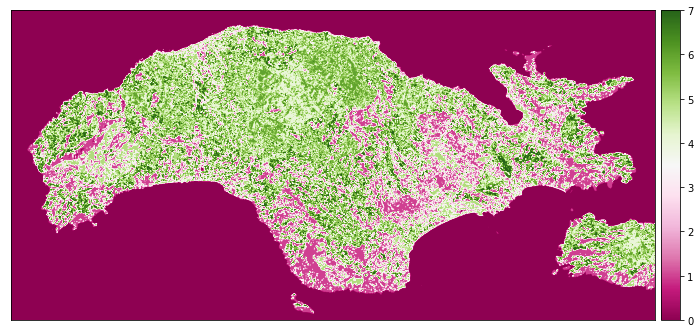

In [ ]:

src = rio.open(result_folder + default_year + "/unsupervised_classified.tif")
ep.plot_bands(src.read(1), 
              cmap='PiYG',
              scale=False)

##Supervised classification
Supervised classification is based on the idea that a user can select sample pixels in an image that are representative of specific classes and then direct the image processing software to use these training sites as references for the classification of all other pixels in the image. Training sites (also known as testing sets or input classes) are selected based on the knowledge of the user. The user also sets the bounds for how similar other pixels must be to group them together. These bounds are often set based on the spectral characteristics of the training area, plus or minus a certain increment (often based on “brightness” or strength of reflection in specific spectral bands). The user also designates the number of classes that the image is classified into. Many analysts use a combination of supervised and unsupervised classification processes to develop final output analysis and classified maps.

Aerial images cover the entire globe at various spatial and temporal resolutions. Timely extraction of information from aerial images requires automated analysis to train computers to recognize what the human eye immediately identifies. Object-based image analysis (OBIA) improves processing efficiency by implementing image segmentation algorithms to combine groups of pixels into objects (segments) reducing the amount of information in and image.

### 1. Image Segmentation
The image user in unsupervised classification is a portion of an satellite image collected by NASA. The horizontal image resolution is 30 meter. Our first task is to group similar pixels into segments. Segmentation effectively reduces the number of elements in an image that need to be classified. This may reduce an image with 1 million pixels down to 50,000 segments, which is much more manageable.

A number of segmentation algorithms are available. We won’t go into details. I will show you results from two different algorithms, and how to implement them in Python with skimage.

The code below demonstrates segmentation with the quickshift algorithms. First, each of the bands from the LANDSAT image is read as a numpy array with gdal. Band data are re-scaled to intensity values (ranging from 0–1). Then segments are created. Segments are saved to a new raster with gdal.

In [ ]:
# read in image to classify with gdal
naip_fn = result_folder + default_year + "/stack_indices.tif"
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
nbands = naip_ds.RasterCount

band_data = []

for i in range(1, nbands+1):
    band = naip_ds.GetRasterBand(i).ReadAsArray()
    band_data.append(band)
band_data = np.dstack(band_data)
img = exposure.rescale_intensity(band_data)
img = img.astype('float')

# do segmentation, different options with quickshift (only use one of the next two lines)
segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)
 
# save segments to raster
segments_fn = result_folder + year + "/segments.tif"
segments_ds = driverTiff.Create(segments_fn, naip_ds.RasterXSize, naip_ds.RasterYSize,
                                1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(naip_ds.GetGeoTransform())
segments_ds.SetProjection(naip_ds.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

The image below demonstrate how the segmentation algorithm and parameters affect the size and shape of the image segments. Features in your image may be best represented by a different algorithm, or different algorithm parameters. Be sure to assess your segments before continuing with classification. But perhaps it is more easier to download the image, and zoom to small areas to see actual differences.

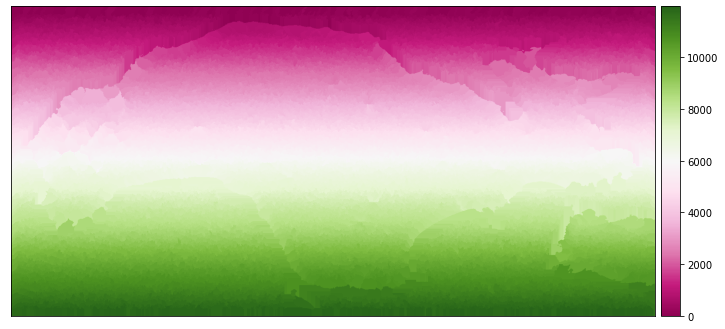

In [ ]:
src = rio.open(segments_fn)
ep.plot_bands(src.read(1), 
              cmap='PiYG',
              scale=False)

### 2. Spectral Properties of Image Segments
Once the image is segmented the spectral properties of each segment must be quantitatively described. Given a number of pixels, the function below calculates descriptive statistics (e.g. mean, max, min, variance) for each band. These are the values that will be used by the random forests algorithm to classify the segments into land cover types.

In [ ]:
def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features

Now, we loop through each segment, send the pixels from each segment to the segment_features function and save the results in a list. This section of code will likely be the bottleneck in your processing time. It can be improved with parallelization, but that isn’t discussed here.

In [ ]:
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### 3. Truth (Training and Test) Data
This is a supervised classification workflow, so you’ll need to have some truth data describing the land cover types represented in your classification. I quickly generated the points in QGIS to represent few different land cover classes. These data are just an example. Ideally, you would have data collected in a more organized and statistically rigorous manner. My land cover data are in shapefile format. The code below uses geopandas to read the truth data as a geodataframe. 

In [ ]:
# read shapefile to geopandas geodataframe
gdf = gpd.read_file('/content/drive/My Drive/archipelagos_python/supervised_classification/truth/truth_landuse.shp')
# get names of land cover classes/labels
class_names = gdf['label'].unique()
# create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
# create a pandas data frame of the labels and ids and save to csv
df = pd.DataFrame({'label': class_names, 'id': class_ids})
df.to_csv('/content/drive/My Drive/archipelagos_python/supervised_classification/truth/class_lookup.csv')
# add a new column to geodatafame with the id for each class/label
gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))

The land cover truth data need to be split into training and test data sets. The training data set will train the random forests classification algorithm. We will compare the classification results to the test data set to assess classification accuracy. Randomly, 70% of the truth observations are assigned to a training data set and the remaining 30% to a testing data set. The training and test data sets are each saved to a new shapefile. During this process I also used a lookup table that I created to give names to each land cover class. This is not necessary, but makes it easier to see what each class represents.


In [ ]:
# split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.7)  # 70% of observations assigned to training data (30% to test data)
gdf_test = gdf.drop(gdf_train.index)
# save training and test data to shapefiles
gdf_train.to_file('/content/drive/My Drive/archipelagos_python/supervised_classification/truth/train_data.shp')
gdf_test.to_file('/content/drive/My Drive/archipelagos_python/supervised_classification/truth/test_data.shp')

Now, convert the training data to raster format so each observation point can be associated with an image segment.

In [ ]:
train_fn = '/content/drive/My Drive/archipelagos_python/supervised_classification/truth/train_data.shp'
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()

Associate each training observation with the corresponding image segment. Lines 13–19 ensure that each training observation is associated with only one segment. Because segments include multiple pixels, it is possible that segments represent multiple land cover types. This is why it is important to properly tune your segmentation algorithm.

In [ ]:
# rasterized observation (truth, training and test) data
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# get unique values (0 is the background, or no data, value so it is not included) for each land cover type
classes = np.unique(ground_truth)[1:]

# for each class (land cover type) record the associated segment IDs
segments_per_class = {}
for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
 
# make sure no segment ID represents more than one class
intersection = set()
accum = set()
for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"

### 4. Land Cover Classification
This is the meat of the analysis. The classification algorithm. First, identify and label the training objects (lines 1–20). This process involves associating a label (land cover type) with the statistics describing each spectral band within the image segment.

Now, everything is now set up to train a classifier and use it to predict across all segments in the image. Here I’m using random forests, a popular classification algorithm. The code to train (fit) the algorithm and make predictions is quite simple (lines 22–24). Simply pass the training objects (containing the spectral properties) and the associated land cover label to the classifier. Once the classifier is trained (fitted) predictions can be made for non-training segments based on their spectral properties. After the predictions are made, save them to raster for display in a GIS (lines 26–43).

In [ ]:
train_img = np.copy(segments)
threshold = train_img.max() + 1  # make the threshold value greater than any land cover class value

# all pixels in training segments assigned value greater than threshold
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label
 
# training segments receive land cover class value, all other segments 0
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

# create objects and labels for training data
training_objects = []
training_labels = []
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
 
classifier = RandomForestClassifier(n_jobs=-1)  # setup random forest classifier
classifier.fit(training_objects, training_labels)  # fit rf classifier
predicted = classifier.predict(objects)  # predict with rf classifier

# create numpy array from rf classifiation and save to raster
clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass
 
mask = np.sum(img, axis=2)  # this section masks no data values
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0
 
clfds = driverTiff.Create(result_folder + default_year + '/supervised_classified.tif', naip_ds.RasterXSize, naip_ds.RasterYSize,
                          1, gdal.GDT_Float32)  # this section saves to raster
clfds.SetGeoTransform(naip_ds.GetGeoTransform())
clfds.SetProjection(naip_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(clf)
clfds = None
 
print('Done!')

In [ ]:
src = rio.open(result_folder + default_year + '/supervised_classified.tif')
ep.plot_bands(src.read(1), 
              cmap='PiYG',
              vmin=0,
              scale=False)